# Wind Power Forecasting

## Context
Here's data of a certain windmill. The aim was to predict the wind power that could be generated from the windmill for the next 15 days. A long term wind forecasting technique is thus required.

## Content
It contains various weather, turbine and rotor features. Data has been recorded from January 2018 till March 2020. Readings have been recorded at a 10-minute interval.

### Interesting Observation
A hybrid ARIMA-ANN model has been tested and given good results for modelling a single variable. Check out the paper

https://www.sciencedirect.com/science/article/abs/pii/S0925231201007020

### Sources
https://www.kaggle.com/theforcecoder/wind-power-forecasting 

https://www.hindawi.com/journals/mpe/2010/684742/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

pd.set_option('display.max_columns', None)


In [2]:
# Unnamed column is actually DateTime.
df = pd.read_csv("Turbine_Data.csv", parse_dates=['Unnamed: 0'])

df.rename(columns={'Unnamed: 0':'DateTime', 'AmbientTemperatue':'AmbientTemperature'}, inplace=True)
df.DateTime = pd.to_datetime(df.DateTime)
df = df.set_index('DateTime')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118224 entries, 2017-12-31 00:00:00+00:00 to 2020-03-30 23:50:00+00:00
Data columns (total 21 columns):
ActivePower                     94750 non-null float64
AmbientTemperature              93817 non-null float64
BearingShaftTemperature         62518 non-null float64
Blade1PitchAngle                41996 non-null float64
Blade2PitchAngle                41891 non-null float64
Blade3PitchAngle                41891 non-null float64
ControlBoxTemperature           62160 non-null float64
GearboxBearingTemperature       62540 non-null float64
GearboxOilTemperature           62438 non-null float64
GeneratorRPM                    62295 non-null float64
GeneratorWinding1Temperature    62427 non-null float64
GeneratorWinding2Temperature    62449 non-null float64
HubTemperature                  62406 non-null float64
MainBoxTemperature              62507 non-null float64
NacellePosition                 72278 non-null float64
ReactivePower     

In [3]:
df.head(5)

,ActivePower,AmbientTemperature,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [4]:
# Observation: The target variable is null on the whole first day.

df[df.ActivePower.isnull() == False].head(1)

,ActivePower,AmbientTemperature,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,-9.96083,NaN,NaN,G01,8.0,2.279088


In [5]:
# Further inspection shows there is no data in any column on the first day (except WTG).

df[:144].isnull().sum()

ActivePower                     144
AmbientTemperature              144
BearingShaftTemperature         144
Blade1PitchAngle                144
Blade2PitchAngle                144
Blade3PitchAngle                144
ControlBoxTemperature           144
GearboxBearingTemperature       144
GearboxOilTemperature           144
GeneratorRPM                    144
GeneratorWinding1Temperature    144
GeneratorWinding2Temperature    144
HubTemperature                  144
MainBoxTemperature              144
NacellePosition                 144
ReactivePower                   144
RotorRPM                        144
TurbineStatus                   144
WTG                               0
WindDirection                   144
WindSpeed                       144
dtype: int64

In [6]:
# Let's remove the first 144 rows as they are useless.

df = df[144:]
df.head(1)

,ActivePower,AmbientTemperature,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,-5.357727,23.148729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,-9.96083,NaN,NaN,G01,8.0,2.279088


In [7]:
def drop_constant_columns(df):
    '''Finds and removes any constant columns from the dataframe.
    Action is performed in place.'''
    drop_cols = list()
    for col in df.columns:
        if df[col].value_counts().size == 1:
            print(f"All entries in `{col}` column are `{df[col][0]}`.")
            drop_cols.append(col)
    if not drop_cols:
        print("No constant columns found.")
    else:
        print("Dropping columns...")
        df.drop(columns=drop_cols, inplace=True)
        
            
drop_constant_columns(df)

All entries in `ControlBoxTemperature` column are `nan`.
All entries in `WTG` column are `G01`.
Dropping columns...


In [8]:
# We have a lot of missing data.

df.isnull().sum() / df.shape[0]     # Given as percentages

ActivePower                     0.197578
AmbientTemperature              0.205479
BearingShaftTemperature         0.470545
Blade1PitchAngle                0.644343
Blade2PitchAngle                0.645232
Blade3PitchAngle                0.645232
GearboxBearingTemperature       0.470359
GearboxOilTemperature           0.471223
GeneratorRPM                    0.472434
GeneratorWinding1Temperature    0.471316
GeneratorWinding2Temperature    0.471130
HubTemperature                  0.471494
MainBoxTemperature              0.470639
NacellePosition                 0.387890
ReactivePower                   0.197595
RotorRPM                        0.473857
TurbineStatus                   0.467243
WindDirection                   0.387890
WindSpeed                       0.198891
dtype: float64

In [9]:
# Thought:
# We might be able to assume that good windmill engineering unsures that
# many of these features are optimized to ActivePower. 
#
# Under this assumption, we can probably ignore most, if not all, non-target features.

In [10]:
# Let's focus on our target, ActivePower.
# Observation: ActivePower can be negative, apparently.

power = df.ActivePower.copy()
power.describe()

count    94750.000000
mean       619.109805
std        611.275373
min        -38.524659
25%         79.642258
50%        402.654893
75%       1074.591780
max       1779.032433
Name: ActivePower, dtype: float64

In [11]:
# Too many negative values to be considered anomalies.
# Perhaps this is normal.

power[power < -1].describe()

count    15499.000000
mean        -6.169591
std          1.563767
min        -38.524659
25%         -6.738149
50%         -5.830176
75%         -5.317955
max         -1.014681
Name: ActivePower, dtype: float64

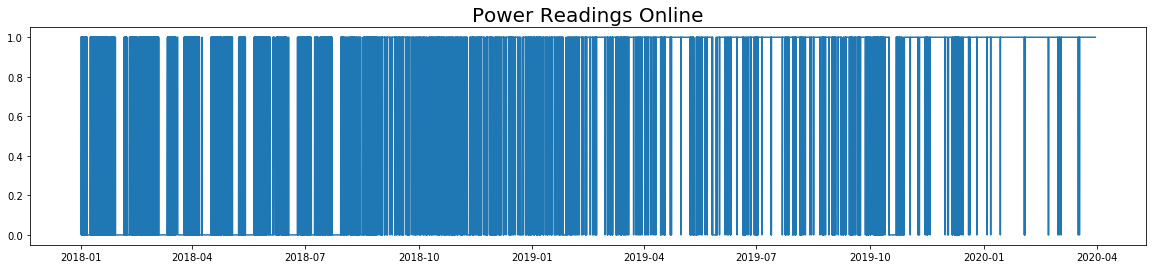

In [12]:
# ~20% of the target values (ActivePower) are null.
# I am worried that whole days worth of chunks are null.
# This could cause problems with reliability, splitting data, interpolation, etc.

power_readings_online = power.isnull()
power_readings_online.replace({True:0, False:1}, inplace=True)

plt.figure(figsize=(20,4))
plt.plot(power_readings_online[:-15])
plt.title('Power Readings Online', fontsize=20)
plt.show()


The above line graph is slightly misleading. A vertical blue line occurs when an on-off or off-on switch occurs.

The most concerning parts is where there is a visible horizontal blue line at y=0, notably in 2018. These are long periods of time where there are no readings for our target variable. 

In [13]:
# Find days for which ActivePower is almost always null.
# There are 99 days for which there are over 99 null readings for ActivePower

power_null_per_day = power.isnull().groupby(pd.Grouper(level='DateTime', freq='D')).sum()
power_null_per_day[power_null_per_day>99]


DateTime
2018-01-06 00:00:00+00:00    127.0
2018-01-07 00:00:00+00:00    144.0
2018-01-29 00:00:00+00:00    144.0
2018-01-30 00:00:00+00:00    144.0
2018-01-31 00:00:00+00:00    144.0
                             ...  
2019-10-18 00:00:00+00:00    144.0
2019-10-19 00:00:00+00:00    144.0
2019-10-20 00:00:00+00:00    144.0
2019-10-21 00:00:00+00:00    104.0
2019-10-27 00:00:00+00:00    142.0
Name: ActivePower, Length: 99, dtype: float64

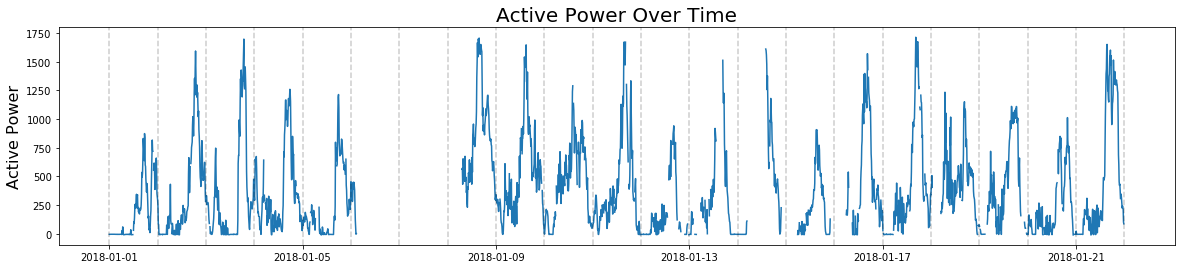

In [14]:
# Observations: 
# 1) Power exhibits daily periodic behavior.
# 2) Spikes usually occur mid-late day.
# 3) Periods of zero ActivePower often occur in the morning, but not always.
# 4) There exist large chunks of missing data (we already knew this)

plt.figure(figsize=(20,4))
plt.plot(power[:3024])    # Three weeks of data 3024 = 6*24*7*#
plt.title('Active Power Over Time', fontsize=20)
plt.ylabel('Active Power', fontsize=16)
for day in range(1, 23):
    plt.axvline(datetime(2018, 1, day), linestyle='--', color='k', alpha=0.2)

## Downsampling 
The task at hand is to predict 15 *days* of ActivePower. Since our time series enjoys a fine sampling frequency of 10 minutes, we might benefit from downsampling. Since there is a clear daily seasonal behavior, it would be most natural to downsample to a new frequency of 1 day.

I also believe this strategy will help mitigate some of the problems that our large amount of missing target data presents. It will be easier to interpolate when there are fewer consecutive null readings in the target variable.

### Aggregate by Mean
It would be best to aggregate the data by taking the mean over each day. This is because the approximation of total energy generated per day is preserved by the mean over time. To elaborate, Active Power $P$ is the rate of energy $E$. This means that we may approximate the energy generated per day by a Riemann sum
$$E_\approx = \sum_{i=1}^{N} P_i * 10$$
where the sum is over each 10-minute interval $i$ in the day, $N=6*24$ is the number of time intervals, and $P_i$ is the Active Power reading at that interval. This is equal to 
$$E_\approx = \Big(\sum_{i=1}^{N} P_i \Big) / N * 10N = \bar{P} * 10N$$
where $\bar{P}$ is the mean of the $P_i$. 


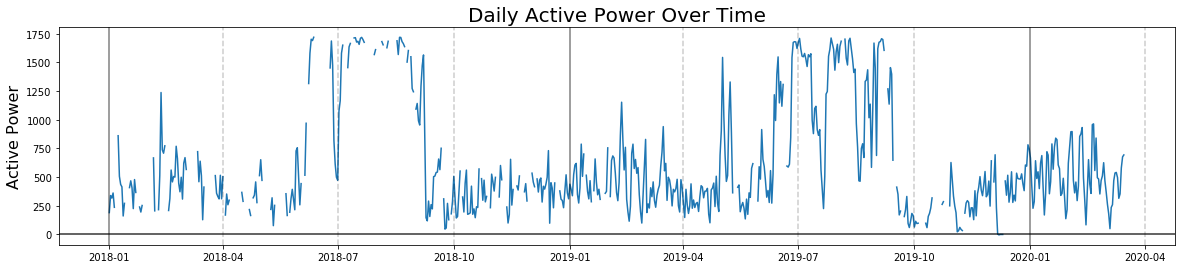

In [15]:
# Group target by day and aggregate by mean
power_daily = power.copy()
power_daily = power.groupby(pd.Grouper(level='DateTime', freq='D')).agg('mean')


# How many null readings per day defines an unreliable day? Max=6*24=144
null_threshold = 50

power_daily.rename('power_daily', inplace=True)
power_null_per_day.rename('power_null_per_day', inplace=True)
assert power_daily.size == power_null_per_day.size

# Set days with an unreliable number of readings to null
power_daily_info = pd.concat([power_daily, power_null_per_day], axis=1)
power_daily_info.loc[power_daily_info.power_null_per_day > null_threshold, 'power_daily'] = np.NaN

# Plotting
plt.figure(figsize=(20,4))
plt.plot(power_daily_info.power_daily[:-15])   
plt.title('Daily Active Power Over Time', fontsize=20)
plt.ylabel('Active Power', fontsize=16)

plt.axhline(0, linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 1, 1), linestyle='-', color='k', alpha=0.5)
plt.axvline(datetime(2020, 4, 1), linestyle='--', color='k', alpha=0.2)
for year in range(2018, 2020):
    plt.axvline(datetime(year, 1, 1), linestyle='-', color='k', alpha=0.5)
    for month in range(4, 12, 3):
        plt.axvline(datetime(year, month, 1), linestyle='--', color='k', alpha=0.2)




### Interpolation

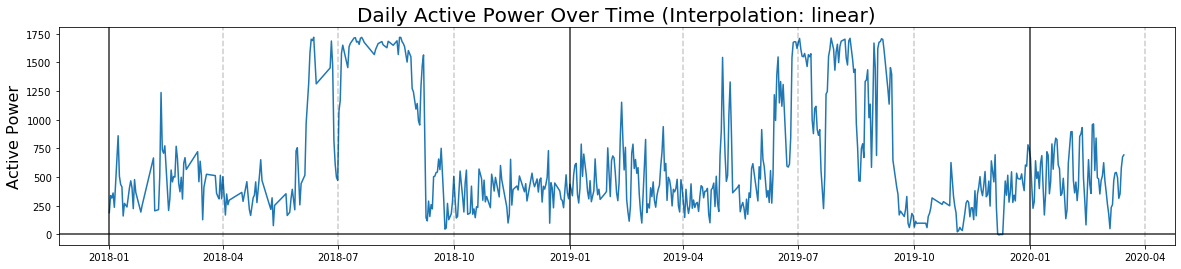

In [16]:
# Interpolate data
method = 'linear'
interpolated_daily = power_daily_info.power_daily.interpolate(method=method)

# Plotting
plt.figure(figsize=(20,4))
plt.plot(interpolated_daily[:-15])   
plt.title(f'Daily Active Power Over Time (Interpolation: {method})', fontsize=20)
plt.ylabel('Active Power', fontsize=16)

plt.axhline(0, linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 1, 1), linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 4, 1), linestyle='--', color='k', alpha=0.2)
for year in range(2018, 2020):
    plt.axvline(datetime(year, 1, 1), linestyle='-', color='k', alpha=0.8)
    for month in range(4, 12, 3):
        plt.axvline(datetime(year, month, 1), linestyle='--', color='k', alpha=0.2)

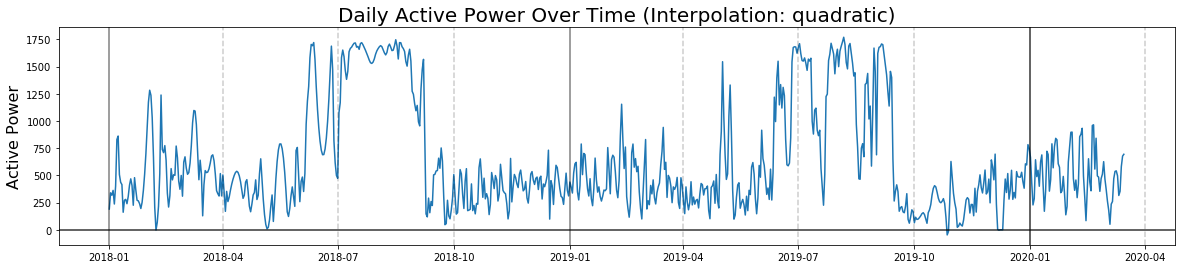

In [17]:
# Interpolate data
method = 'quadratic'
interpolated_daily = power_daily_info.power_daily.interpolate(method=method)

# Plotting
plt.figure(figsize=(20,4))
plt.plot(interpolated_daily[:-15])   
plt.title(f'Daily Active Power Over Time (Interpolation: {method})', fontsize=20)
plt.ylabel('Active Power', fontsize=16)

plt.axhline(0, linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 1, 1), linestyle='-', color='k', alpha=0.8)
plt.axvline(datetime(2020, 4, 1), linestyle='--', color='k', alpha=0.2)
for year in range(2018, 2020):
    plt.axvline(datetime(year, 1, 1), linestyle='-', color='k', alpha=0.5)
    for month in range(4, 12, 3):
        plt.axvline(datetime(year, month, 1), linestyle='--', color='k', alpha=0.2)

In [18]:
# Let's go with quadratic, it looks more "realistic".
power_daily = interpolated_daily

## Train-Test Split

Let's set aside the final 15 days for our test data.

In [19]:
y = power_daily[-15:]
X = power_daily[:-15]

## Further Exploration

In [20]:
from statsmodels.tsa.stattools import adfuller

def adf_summary(X):
    '''Applies the Automated Dickey-Fuller test.
    Null-hypothesis: The time series is not stationary.'''
    adf = adfuller(X)
    print(f'ADF Statistic: {adf[0]}')
    print(f'p-value: {adf[1]}')
    print('Critical Values:')
    for key, value in adf[4].items():
        print(f'\t{key}: {value}')

    if adf[0] < adf[4]['5%']:
        print("Reject Null: Assume time series is stationary.")
    else:
        print("Fail to reject null: Time series may not be stationary.")

adf_summary(power_daily[:-15])


ADF Statistic: -3.105431777183031
p-value: 0.026153815385582355
Critical Values:
	1%: -3.438623132449471
	5%: -2.8651915799370014
	10%: -2.568714441670417
Reject Null: Assume time series is stationary.


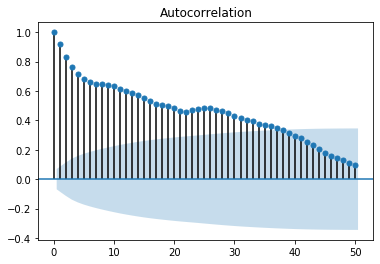

In [21]:
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Decays
# The rate of decay is slow

acf_plot = plot_acf(X, lags=50)

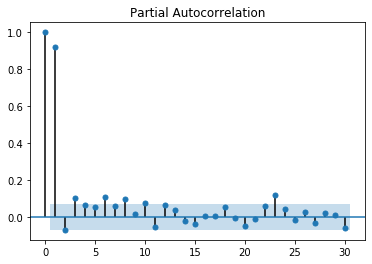

In [22]:
# Drops off quickly
# Significant lags: 1, 2(?), 3, 6, 8, 10(?), 23(?)

pacf_plot = plot_pacf(X)

## AutoRegressive (AR) Model

Let's try an AR model. This decision is based the rule of thumb that the ACF decays slowly while the PACF quickly drops for an AR time series. 

An AR model is a regression 
$$ X_t = \beta_0 + \beta_1 X_{t-1} + \dots + \beta_p X_{t-p} + \epsilon_t $$
where $X_i$ is the value of $X$ at time $i$, $\beta_j$ are the parameters, and $\epsilon_t$ is the error. In English, this says that the value of $X$ at any time $t$ is a constant plus some fixed linear combination of the values of $X$ at the previous $p$ time steps, within some level of error. 

The value $X_{t-i}$ is called the $i$-th lag of $X_t$. A rule of thumb says that the significant lags coincide with the values of the PACF curve that are large enough. Remember that the PACF plots the direct effect of $X_{t-i}$ on $X_t$. If the direct effect is small, then we may consider excluding it from our model. 

We can estimate the significant $\beta_i$ using an OLS method. We will tune the values of $\beta_i$ by a Walk Forward Validation. This simulates the process of updating a model as new information comes in.


In [23]:
from TimeSeriesHelpers import compare_AR_models

# Lag sets based on the PACF function.
lags0 = [1, 2, 3]
lags1 = [1, 2, 3, 6]
lags2 = [1, 2, 3, 6, 8]
lags3 = [1, 2, 3, 6, 8, 10]
lags4 = [1, 2, 3, 6, 8, 10, 23]
lag_sets = [lags0, lags1, lags2, lags3, lags4]

compare_AR_models(lag_sets, X, h=30)


Window Size: 150	Num Windows: 22

Test 0: AR(lags=[1, 2, 3])
RMSE Mean: 463.93	RMSE Variance: 67759.15

Test 1: AR(lags=[1, 2, 3, 6])
RMSE Mean: 443.63	RMSE Variance: 67350.19

Test 2: AR(lags=[1, 2, 3, 6, 8])
RMSE Mean: 431.94	RMSE Variance: 78801.06

Test 3: AR(lags=[1, 2, 3, 6, 8, 10])
RMSE Mean: 426.26	RMSE Variance: 79537.41

Test 4: AR(lags=[1, 2, 3, 6, 8, 10, 23])
RMSE Mean: 414.34	RMSE Variance: 74486.15



In [24]:
compare_AR_models(lag_sets, X, h=45)

Window Size: 225	Num Windows: 13

Test 0: AR(lags=[1, 2, 3])
RMSE Mean: 419.92	RMSE Variance: 36451.39

Test 1: AR(lags=[1, 2, 3, 6])
RMSE Mean: 398.20	RMSE Variance: 33069.40

Test 2: AR(lags=[1, 2, 3, 6, 8])
RMSE Mean: 402.27	RMSE Variance: 42442.50

Test 3: AR(lags=[1, 2, 3, 6, 8, 10])
RMSE Mean: 397.47	RMSE Variance: 42351.46

Test 4: AR(lags=[1, 2, 3, 6, 8, 10, 23])
RMSE Mean: 454.26	RMSE Variance: 81456.71



In [25]:
compare_AR_models(lag_sets, X, h=60)

Window Size: 300	Num Windows: 9

Test 0: AR(lags=[1, 2, 3])
RMSE Mean: 454.99	RMSE Variance: 44210.40

Test 1: AR(lags=[1, 2, 3, 6])
RMSE Mean: 430.46	RMSE Variance: 45378.76

Test 2: AR(lags=[1, 2, 3, 6, 8])
RMSE Mean: 420.55	RMSE Variance: 45857.16

Test 3: AR(lags=[1, 2, 3, 6, 8, 10])
RMSE Mean: 410.98	RMSE Variance: 46766.61

Test 4: AR(lags=[1, 2, 3, 6, 8, 10, 23])
RMSE Mean: 416.45	RMSE Variance: 60172.30



Let's choose the lags from Test 1. It has a fairly low RMSE Mean scores while maintaining a relatively low RMSE Variance scores. It also has a smaller number of parameters which is a good number to try to keep low.

Let's choose the AR(lags1) model which has been optimized on the forecast horizon size `h=45` since the model does the best for this value of `h`.